In [1]:
# -*- coding: utf-8 -*-

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

import tensorflow as tf
import numpy as np
import time

def initialize_session():
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.4
    return tf.Session(config=config)


/etc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
##################################################
BATCH_SIZE = 100
class_size = 4
learning_rate = 0.0005   # Learning rate
use_clip = True         # Gradient clipping 쓸지 여부
train_keep_prob = 0.7
max_len = 200           # sequence 단어 수 제한
max_vocab = 40000       # maximum 단어 개수
emb_dim = 128            # 단어 embedding dimension
hidden_dim = 128        # RNN hidden dim
train_acc_summary = [] # 학습용 데이터의 정확도를 중간 중간 기록한다
test_acc_summary = []  # 테스트용 데이터의 정확도를 중간 중간 기록한다
train_loss_summary = [] # 학습용 데이터의 정확도를 중간 중간 기록한다
test_loss_summary = []  # 테스트용 데이터의 정확도를 중간 중간 기록한다
hypothesis_summary = []
##################################################
from ensemble_loader import movie_data
data = movie_data(max_vocab=max_vocab, max_len=max_len)

train_total_batch = int(data.train_size / BATCH_SIZE)
test_total_batch = int(data.test_size / BATCH_SIZE)

from genre_ensemble_model_v3 import Model
model = Model(max_len=max_len,
              emb_dim=emb_dim,
              hidden_dim=hidden_dim,
              vocab_size=max_vocab,
              class_size=class_size,
              use_clip=True, learning_rate=learning_rate)

sess = initialize_session()
sess.run(tf.global_variables_initializer())

Using TensorFlow backend.


x_train size 4800
y_train size 4800
x_test  size 1200
y_test  size 1200
x_ids_train  size 4800
x_len_train  size 4800
x_ids_test  size 1200
x_len_test  size 1200
(?, 128)


In [3]:
model.restore(sess)

 - Restoring variables...
Instructions for updating:
Please use tf.global_variables instead.
INFO:tensorflow:Restoring parameters from models/model
 * model restored 


In [4]:
BATCH_SIZE

100

In [64]:
def test_model():
    test_loss, test_acc = 0, 0
    t_result = []
    f_result = []
    hypothesys_true = []
    hypothesys_false = []
    for _ in range(test_total_batch):
        test_movieid = data.get_test_movieid(BATCH_SIZE)
        test_x_img, test_ids, test_length, test_y = data.get_test(BATCH_SIZE)
        

        _hypothesys, pred = sess.run([model.genre_prob, model.y_pred],
                              feed_dict={model.x_image: test_x_img, model.x_ids: test_ids, model.x_len: test_length,
                              model.y_label: test_y, model.keep_prob : 1.0, model.is_training:False})
        

        for i, p in enumerate(pred):
            if test_y[i] == p:
                t_result.append((p, test_y[i], test_movieid[i], i))
                hypothesys_true.append(_hypothesys[i])
            else:
                f_result.append((p, test_y[i], test_movieid[i], i))
                hypothesys_false.append(_hypothesys[i])

    return t_result, hypothesys_true, f_result, hypothesys_false

In [65]:
t_result, hypothesys_t, f_result,  hypothesys_f= test_model()

In [66]:
data.movieid_2_genre[1712159]

'Horror'

In [67]:
data.labelid_2_genre

{0: 'Romance', 1: 'Horror', 2: 'Adventure', 3: 'Documentary'}

In [48]:
#romance
 (0, 0, 2994832, 5),
 (0, 0, 126916, 31),

#Horror
 (1, 1, 376650, 24),
(1, 1, 1179056, 62),

#Adventure
 (2, 2, 2312390, 65),
 (2, 2, 98205, 72),

#Documentary
 (3, 3, 4477936, 79),
 (3, 3, 1597089, 84),

(3, 354623, 76)

In [81]:
t_result
c1, c2, c3, c4 = 0, 0, 0, 0
for a, b, c, d in t_result:
    if a == 0:
        c1 += 1
    elif a == 1:
        c2 += 1
    elif a == 2:
        c3 += 1
    elif a == 3:
        c4 += 1

print(c1, c2, c3, c4)

216 230 197 242


In [43]:
#romance
(2, 0, 284837, 42)
(3, 0, 3142232, 22)

#Horror
(2, 1, 239641, 96)
(0, 1, 74287, 97)

#Adventure
(0, 2, 823451, 71)
(1, 2, 1228915, 9)

#Documentary
(2, 3, 1581829, 83)
(0, 3, 1495768, 79)

(3, 118949, 79)

In [76]:
f_result[0]

1

In [56]:
hypothesys_f[36]

array([5.9403926e-03, 1.0189525e-03, 9.9237436e-01, 6.6630985e-04],
      dtype=float32)

In [75]:
type(f_result[0])

tuple

In [86]:
c1, c2, c3, c4 = 0, 0, 0, 0
for a, b, c, d in f_result:
    if a == 3:
        if b == 0:
            c1 +=1
        elif b == 1:
            c2 +=1
        elif b == 2:
            c3 +=1

print(c1, c2, c3, c4)

7 2 25 0


In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

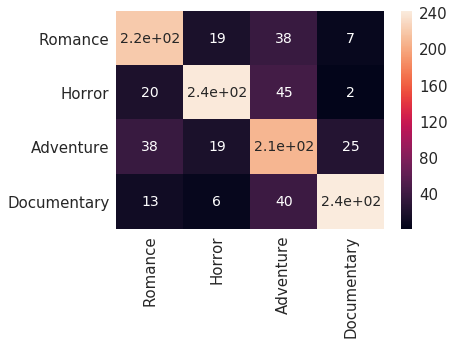

In [111]:
m = [[221,19,38,7],
     [20,241,45,2],
    [38,19, 209,25],
    [13,6,40,242],]
df_cm = pd.DataFrame(m, index=["Romance", "Horror", "Adventure", "Documentary"], 
                     columns=["Romance", "Horror", "Adventure", "Documentary"])
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.5)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 14})# font size